In [ ]:
# Importing modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
# Loading dataset and exploring for missing values
heart = pd.read_csv("framingham.csv")
heart.head()
#heart.isnull().sum()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [ ]:
heart_fill = heart
heart_fill['cigsPerDay'].fillna(heart_fill.groupby('currentSmoker')['cigsPerDay'].transform('mean'),inplace=True)
heart_fill['BPMeds'].fillna(heart_fill.groupby('prevalentHyp')['BPMeds'].transform('median'),inplace=True)
heart_fill['totChol'].fillna(heart_fill.groupby('prevalentStroke')['totChol'].transform('mean'),inplace=True)
heart_fill['BMI'].fillna(heart_fill.groupby('age')['BMI'].transform('mean'),inplace=True)
heart_fill['heartRate'].fillna(heart_fill.groupby('sysBP')['heartRate'].transform('mean'),inplace=True)
heart_fill['glucose'].fillna(heart_fill.groupby('diabetes')['glucose'].transform('mean'),inplace=True)
heart_fill['education'].fillna(heart_fill.groupby('age')['education'].transform('mean'),inplace=True)
heart.isnull().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

<AxesSubplot:>

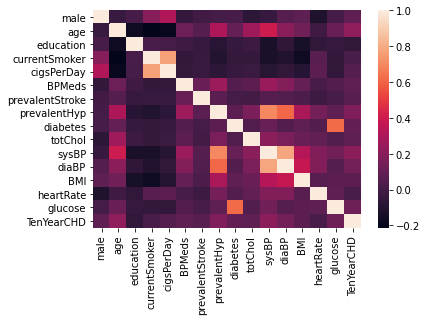

In [ ]:
# Correlation matrix
sns.heatmap(heart_fill.corr())

<AxesSubplot:>

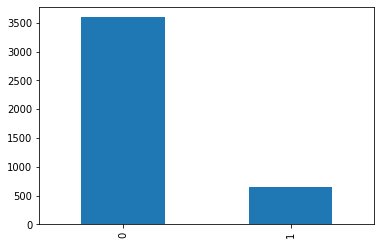

In [ ]:
# Exploring response variable distribution (how can you build the mass function from this)
heart_fill['TenYearCHD'].value_counts().plot(x=heart_fill['TenYearCHD'], kind='bar')

<AxesSubplot:xlabel='gender', ylabel='count'>

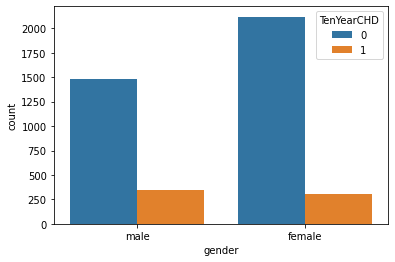

In [ ]:
# Exploring association between gender and CHD
heart_fill_plot = heart_fill.copy()
heart_fill_plot['male'] = heart_fill_plot['male'].replace({0:'female', 1:'male'})
heart_fill_plot = heart_fill_plot.rename(columns={'male':'gender'})
sns.countplot(data=heart_fill_plot,x='gender', hue='TenYearCHD')

<AxesSubplot:xlabel='diabetes', ylabel='count'>

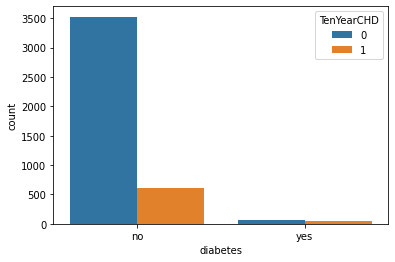

In [ ]:
# Exploring relation between diabetes and CHD
heart_fill_plot['diabetes'] = heart_fill_plot['diabetes'].replace({0:'no', 1:'yes'})
sns.countplot(data=heart_fill_plot,x='diabetes', hue='TenYearCHD')

In [ ]:
# Model implementation
def logistic_regression_metrics(df, target, testSize):
    split = StratifiedShuffleSplit(n_splits = 1, test_size = testSize, random_state = 42)
    lr = LogisticRegression()
    for train_index, test_index in split.split(df, df[target]):
        train = df.loc[train_index]
        test = df.loc[test_index]
        
        x = train.drop([target], axis = 1)
        y = train[target]
        
        a = test.drop([target], axis=1)
        b = test[target]
        
        lr.fit(x,y)
        
        predicted = lr.predict(a)
        accuracy = accuracy_score(b, predicted)
        c_m = confusion_matrix(b, predicted)
        return print('Accuracy score:', accuracy, '\n', 'Confusion matrix:\n', c_m.T)

In [ ]:
logistic_regression_metrics(heart_fill, 'TenYearCHD', 0.2)

Accuracy score: 0.8502358490566038 
 Confusion matrix:
 [[714 122]
 [  5   7]]


/home/rafa/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Ejercicio: 

1. Normaliza o estandariza las variables numéricas del dataset y compara los valores de la matriz de confusión del modelo ajustado sobre este nuevo dataset estandarizado. ¿Notas alguna diferencia?

2. ¿Recuerdas KNN?, ajusta un modelo de KNN para este dataset y compara la matriz de confusión obtenida, ¿qué modelo es más adecuado?, ¿por qué?

### Generando un poco de intuición alrededor de la regresión logística:

En el modelo de regresión logística tenemos una variable dependiente con distribución binomial. Por lo que en lugar de tener un modelo lineal de la forma:

$$h(x)=\hat Y = \beta^TX$$

tenemos que $\hat Y$ será expresada de la siguiente manera:

Consideremos $P\{Y=1\}=p$, entonces:

$$\hat Y = log({p\over1-p}) = \beta^TX~~~~~~~~~~(1)$$

haciendo un poco de álgebra es fácil ver que:

$$p = {1 \over 1 + e^{-\beta^TX}}~~~~~~~~~~(2)$$

**Ejercicio:** prueba lo anterior.

De $(1)$ podemos definir un concepto conocido como **razón de momios** u **odds ratio** por su nombre en inglés. El cual hace referencia a la expresión:

$$p\over1-p$$

Nótese que esta expresión nos habla de qué tan grande o cuántas veces es más probable que ocurra el evento exitoso en relación con el evento fracaso. 

Por lo tanto si $p$ aumenta, la razón de momios también lo hace así. El logaritmo es una función monótona creciente, por lo que podemos concluir que el logaritmo de la razón de momios también se incrementa al incrementarse la probabilidad de éxito. 

Por lo tanto si el coeficiente $\beta_i$ correspondiente a la variable independiente $X_i$ son positivos o grandes, éstos estarán contribuyendo positivamente al aumento de la probabilidad de detectar un éxito. De manera contraria si estos coeficientes son grandes pero negativos contribuirán a la disminución de la probabilidad de éxito, si el valor absoluto de algún coeficiente en particular es pequeño en comparación con el de los demás o cercano a cero podemos decir que dichas variables no afectan 'mucho' el ajuste generado.

Estas mismas conclusiones se pueden generar a partir de la expresión $(2)$.